
# PROJECT SURFRIDER (2019-2020) 
Author: Mithuran GAJENDRAN, Hugo MALLET


![](https://zupimages.net/up/19/09/1gz8.png)

![](https://raw.githubusercontent.com/m2dsupsdlclass/project-surfrider/master/imgs/surfrider.png)

* This course project makes use of an ongoing open source project led by Surfrider Europe, which aims at quantifying plastic pollution in rivers through space and time. Plastic Waste in oceans mostly comes from rivers (80%), and it is very difficult to assess precisely where they come from. This will be used to monitor river banks to take local decisions, measure effectiveness of policies at local and global scales, and has thus a very concrete importance.
* In practice, video streams are captured on river banks from kayaks (with their geolocalisation), and then fed to a model which aims at quantifying the number and types of objects. 
* Our goal is to build a short project around plastic detection using modern Deep Learning algorithms and also **provide ideas to tackle this issue**.



We both are trying to reduce our ecological footprint and are engaged in environmental issues. Moreover, we fancy kayaking too. 

Therefore, rather than implementing a model straight away, **we decided to brainstorm**. These are the keypoints we found interesting:
* In rough water, this mission would be inefficient as the plastic would be moving fast, we considered kayaking only calm water. What do we usually have ? Our smartphones !
* People tend to kayak for leasure purpose: they park there car at spot A, enjoy their adventure till point B before heading back to point A. In other words, rather than feeding a model afterwards, they could be feeding the model while reaching point B. Then the algorithm will focus them to the dirtiest area while they are heading back to point A. 
* While kayaking, we tend to put our cells on airplane mode to reduce battery consumption. 

Having considered the aforementionned keypoints, and having iPhones, we decided to build a solution that would work on Apples ecosystem.


Luckily, Apple introduced few years ago Apple ML.

A brief history of Apple ML:

* Core ML: Announced at WWDC 2017, and supports every major ML models. However, they are too big to load or not specific enough to tackle our issues.
* Turi Create: Acquired by Apple after WWDC 2017, it lets you customize existing models with your own data in Python Allélouiaaaa.

### Aim:
* Use Deep Learning algorithm/methods to maximize our performance in detecting objects.
* Do it on IOS ecosystem
*Provide a different point of view to tackle this plastic issue that seems to be more efficient ( according to our thoughts ahaha ! )

## Start

Object detection is the task of simultaneously classifying (what) and localizing (where) object instances in an image. This is our goal for the moment.
### Imports & Settings

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks/SurfRider'

/content/gdrive/My Drive/Colab Notebooks/SurfRider


In [3]:
#colab = True
!pip install turicreate==5.8
# The wrong version of MXNET will be installed
!pip uninstall -y mxnet
# Install CUDA10-compatible version of mxnet 
!pip install mxnet-cu100==1.5.1
!pip install fritz
#!pip install -U turicreate


import os 
import turicreate as tc
tc.config.set_num_gpus(-1)  # USE GPU sinon c'est leeeeeent
path = "dataset_surfrider_cleaned/"
img_path = path+"Images_md5"


     |████████████████████████████████| 90.7MB 50kB/s 
     |████████████████████████████████| 327kB 58.2MB/s 
     |████████████████████████████████| 17.3MB 203kB/s 
     |████████████████████████████████| 23.8MB 130kB/s 
     |████████████████████████████████| 3.4MB 59.8MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=511a00dfddad74bb9e88421a89d1eb6eb8ae266901a02c58a962bdad385d52ce
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built resampy
ERROR: tensorflow-model-optimization 0.2.1 requires enum34~=1.1, which is not installed.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have foli

Uninstalling mxnet-1.1.0.post0:
  Successfully uninstalled mxnet-1.1.0.post0
     |████████████████████████████████| 444.9MB 38kB/s 
     |████████████████████████████████| 51kB 2.6MB/s 


### Data Loading:



Loading the data was actually a real pain. We had to work around a certain solution to import the data properly

In [0]:
need_data_loading = False

if need_data_loading:
  #cwd = os.getcwd()  # Get the current working directory (cwd)
  directory = cwd+"/"+path+"/"+"Images_md5"
  for filename in os.listdir(directory):
      os.rename(directory+ '/'+filename, directory+ '/'+filename+".jpg")


We converted the md5 files to JPG then made two SFRAME (_like a DataFrame in pandas_):
* one to read the data from the JSON
* another one to get the images

We merged the results into the SFRAME SF. It is mandatory: we need the image and perhaps more important its label.

In [4]:
SF = tc.SFrame.read_json(path+"dataset.json",orient="lines")
SF_img = tc.image_analysis.load_images(path+"Images_md5",recursive=True,
                                       random_order=True)
SF_img['md5'] = SF_img['path'].apply(lambda path: path.split('/')[2]).apply(lambda dot: dot.split(".")[0])
SF = SF.join(SF_img, on="md5", how="left")
SF = SF.rename({"labels":"annotations"})

Read 100 lines. Lines per second: 2865.9

Finished parsing file /content/gdrive/My Drive/Colab Notebooks/SurfRider/dataset_surfrider_cleaned/dataset.json

Parsing completed. Parsed 100 lines in 0.035459 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/gdrive/My Drive/Colab Notebooks/SurfRider/dataset_surfrider_cleaned/dataset.json

Parsing completed. Parsed 500 lines in 0.020433 secs.

Read 12 images in 5.43398 secs	speed: 2.20833 file/sec

Read 22 images in 10.5106 secs	speed: 1.9698 file/sec

Read 33 images in 15.593 secs	speed: 2.16433 file/sec

Read 44 images in 20.6151 secs	speed: 2.19034 file/sec

Read 55 images in 25.6488 secs	speed: 2.18528 file/sec

Read 67 images in 31.0096 secs	speed: 2.23846 file/sec

Read 78 images in 36.2734 secs	speed: 2.08972 file/sec

Read 89 images in 41.4879 secs	speed: 2.10952 file/sec

Read 100 images in 46.8065 secs	speed: 2.0682 file/sec

Read 111 images in 51.8864 secs	speed: 2.16544 file/sec

Read 121 images in 57.2213 secs	speed: 1.87444 file/sec

Read 133 images in 62.4072 secs	speed: 2.31397 file/sec

Read 145 images in 67.7838 secs	speed: 2.23189 file/sec

Read 157 images in 73.2327 secs	speed: 2.20227 file/sec

Read 168 images in 78.5337 secs	speed: 2.07509 file/sec

Read 180 images in 83.7181 secs	speed: 2.31464 file/sec

Read 190 images in 88.727 secs	speed: 1.99642 file/sec

Read 202 images in 93.9261 secs	speed: 2.30809 file/sec

Read 213 images in 98.9688 secs	speed: 2.18138 file/sec

Read 225 images in 104.462 secs	speed: 2.18453 file/sec

Read 237 images in 109.646 secs	speed: 2.31476 file/sec

Read 248 images in 114.768 secs	speed: 2.14751 file/sec

Read 259 images in 120.12 secs	speed: 2.05549 file/sec

Read 270 images in 125.297 secs	speed: 2.12456 file/sec

Read 281 images in 130.424 secs	speed: 2.1456 file/sec

Read 293 images in 135.507 secs	speed: 2.36079 file/sec

Read 305 images in 140.742 secs	speed: 2.29221 file/sec

Read 315 images in 145.855 secs	speed: 1.956 file/sec

Read 327 images in 151.227 secs	speed: 2.23361 file/sec

Read 339 images in 156.371 secs	speed: 2.33307 file/sec

Read 348 images in 161.385 secs	speed: 1.79472 file/sec

Read 359 images in 166.518 secs	speed: 2.14324 file/sec

Read 370 images in 171.672 secs	speed: 2.13434 file/sec

Read 381 images in 176.981 secs	speed: 2.07182 file/sec

Read 391 images in 181.991 secs	speed: 1.99593 file/sec

Read 403 images in 187.302 secs	speed: 2.25972 file/sec

Read 415 images in 192.602 secs	speed: 2.26384 file/sec

Read 427 images in 198.026 secs	speed: 2.21262 file/sec

Read 439 images in 203.228 secs	speed: 2.30658 file/sec

Read 451 images in 208.46 secs	speed: 2.29356 file/sec

Read 463 images in 213.524 secs	speed: 2.36965 file/sec

Read 475 images in 218.891 secs	speed: 2.23584 file/sec

Read 487 images in 224.553 secs	speed: 2.11939 file/sec

Read 498 images in 229.742 secs	speed: 2.11987 file/sec

Labels are the most important detail in our dataset: they permit the model to focus its learning on detecting "those bits". Unfortunately, the coordinates of the dataset didn't match the requirements from Apple ML. We blindly, but intelligently processed the data to make it proper.

In [0]:
def clean_annotations(x):
    L=[]
    for idx, el in enumerate(x):
        label = el['label']
        coordinates = el['bbox']
        coordinates = {"x": int(coordinates[0])+int(int(coordinates[2])-int(coordinates[0]))/2,
                       "y": int(coordinates[1])+int(int(coordinates[3])-int(coordinates[1]))/2,
                       "height": int(int(coordinates[3])-int(coordinates[1])),
                      "width": int(int(coordinates[2])-int(coordinates[0]))}
        L.append({"label":label, "coordinates":coordinates})
    return L

In [0]:
SF['annotations'] = SF['annotations'].apply(lambda x: clean_annotations(x))

In [7]:
SF.remove_columns(["md5","size","id_file","format","filename","path"],inplace=True)

annotations,image
"[{'label': 'fragments','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'bottles','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'others','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'fragments','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'fragments','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'bottles','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'fragments','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'fragments','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'others','coordinates': {'x': ...",Height: 600 Width: 600
"[{'label': 'fragments','coordinates': {'x': ...",Height: 600 Width: 600


Here we have it our final SF to feed our model. The following code snippet is interesting: it permits to show the squares around the objects to detect according to the given coordinates.

# ADD TACO DATASET

In [0]:
to_load_Taco = "Taco/to_load_Taco"
Taco = tc.load_sframe(to_load_Taco)

In [0]:
Taco

image,annotations
Height: 640 Width: 480,"[{'label': 'bottles','coordinates': {'x': ..."
Height: 640 Width: 480,"[{'label': 'others','coordinates': {'x': ..."
Height: 640 Width: 480,"[{'label': 'bottles','coordinates': {'x': ..."
Height: 480 Width: 640,"[{'label': 'bottles','coordinates': {'x': ..."
Height: 640 Width: 480,"[{'label': 'others','coordinates': {'x': ..."
Height: 480 Width: 640,"[{'label': 'fragments','coordinates': {'x': ..."
Height: 640 Width: 480,"[{'label': 'others','coordinates': {'x': ..."
Height: 480 Width: 640,"[{'label': 'bottles','coordinates': {'x': ..."
Height: 640 Width: 480,"[{'label': 'bottles','coordinates': {'x': ..."
Height: 640 Width: 480,"[{'label': 'others','coordinates': {'x': ..."


In [0]:
SF = SF.append(Taco)

In [0]:
#SF['image_with_ground_truth'] = tc.object_detector.util.draw_bounding_boxes(SF['image'], SF['annotations'])
#SF.explore()

We then split our dataset in a train and test data before feeding the model. Object_detector is actually a darknet-yolo model. Through transfer learning we will be able to specify our output labels. The training takes hours on a CPU, do it on a GPU ! Seriously.

In [0]:
train_data, test_data = SF.random_split(1)

In [0]:
model = tc.object_detector.create(train_data,batch_size=40, max_iterations=5000,grid_shape=[25,25],model="darknet-yolo")

         To fix this, please install the currently recommended version:

             pip uninstall -y mxnet && pip install mxnet==1.1.0

         If you want to use a CUDA GPU, then change 'mxnet' to 'mxnet-cu90' (adjust 'cu90' depending on your CUDA version):

Using 'image' as feature column
Using 'annotations' as annotations column
Download completed: /var/tmp/model_cache/darknet.params
Setting 'batch_size' to 40
Using GPU to create model (Tesla T4)
+--------------+--------------+--------------+
| Iteration    | Loss         | Elapsed Time |
+--------------+--------------+--------------+
| 1            | 5.329        | 26.1         |
| 4            | 5.318        | 38.3         |
| 7            | 5.324        | 50.6         |
| 10           | 5.218        | 62.8         |
| 13           | 5.134        | 75.0         |
| 16           | 5.396        | 86.3         |
| 19           | 5.560        | 97.5         |
| 22           | 5.519        | 109.2        |
| 25           | 5.400    

Let's save our hardly earned model :)

In [0]:
model.save('SurfRider_yolo_taco2.model')
model.export_coreml('SurRider_coreML_yolo_taco2.mlmodel')

We can also verify that predictions are working.

In [11]:
#model = tc.load_model("SurfRider_yolo_taco.model")

         To fix this, please install the currently recommended version:

             pip uninstall -y mxnet && pip install mxnet==1.1.0

         If you want to use a CUDA GPU, then change 'mxnet' to 'mxnet-cu90' (adjust 'cu90' depending on your CUDA version):



Predicting 1/1


/usr/local/lib/python3.6/dist-packages/turicreate/aggregate.py:92: UserWarning: Passing parameter(s) to COUNT is deprecated. This functionality will be removed in the next major release. Any passed parameters are ignored.
  + 'the next major release. Any passed parameters are ignored.')


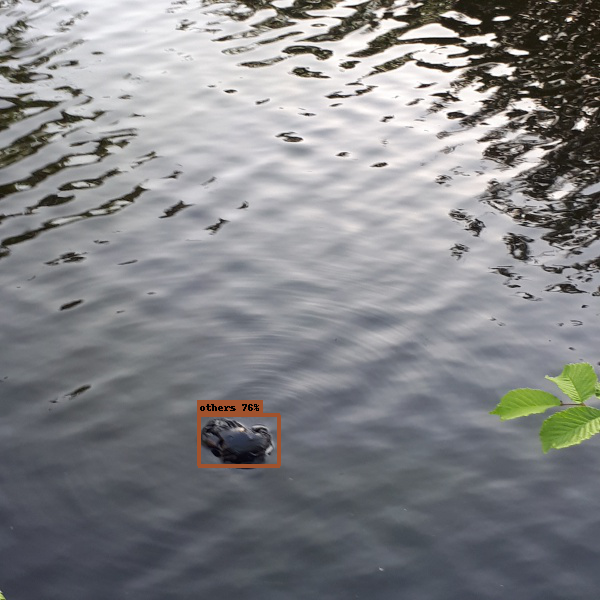

In [15]:
val =3
tc.object_detector.util.draw_bounding_boxes(test_data[val]['image'],
                                            model.predict(test_data[val]['image'],confidence_threshold=0.5))

Predicting 1/1


/usr/local/lib/python3.6/dist-packages/turicreate/aggregate.py:92: UserWarning: Passing parameter(s) to COUNT is deprecated. This functionality will be removed in the next major release. Any passed parameters are ignored.
  + 'the next major release. Any passed parameters are ignored.')


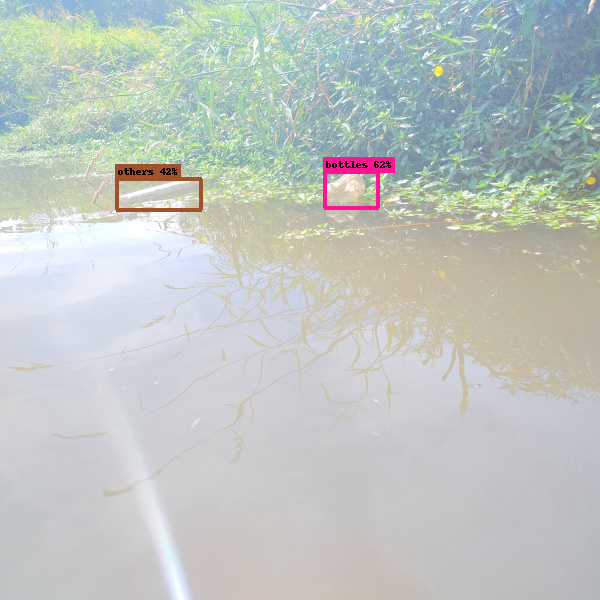

In [21]:
val =20
tc.object_detector.util.draw_bounding_boxes(test_data[val]['image'],
                                            model.predict(test_data[val]['image'],confidence_threshold=0.4))

Comments:
* While testing our app, we found out the model was under performing when an object is well segmented from a plain background. Our training data led to that "over-fitting", this could easily be corrected using new data.
* The lack of classes: the model performs really good with new labels, such as cups, glass jar, metal. We recommend retraining the model by adding those labels, and let the app do the supercategory bucketing in order to have better precision.

We have one big issue with the approach of the project: it is not pro-active. Indeed, it is meant to go get the waste that is accumulating. We prefer the approach of The Great Bubble Barrier
![](http://thegreatbubblebarrier.com/wp-content/uploads/2018/03/Side-view-TGBB.gif)

Their project could be summarized in making water barriers and redirecting wastes towards a storage area rather than leaving it into the water where it is harder to access. Moreover, the barrier will raise sunk plastics. But how is it relevant here ?

With some extra work, our model could give details about the surge of waste. This would help the barrier be efficient and work only on large influx ( or not your policy now :) )

In other words, we think that it would be interesting to change the referential from eulérien to lagragien.
* Camera will be steady, there is no need for after video preprocessing
* Easier to count the influx of garbages than detect and track an object while moving


In [0]:
We learned our AI to detect hidden plastic.

In [0]:
gpu_overload = False
if gpu_overload:
  !kill -9 -1
